В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Оцінка моделі на тренувальних даних:
Area under ROC score on Training dataset: 0.8825


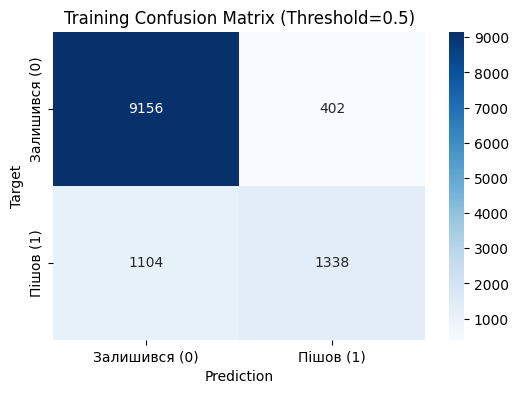

Оцінка моделі на валідаційних даних:
Area under ROC score on Validation dataset: 0.8797


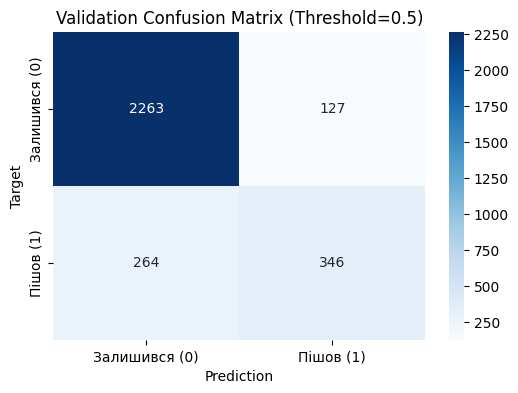

['log_reg_pipeline.joblib']

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

raw_df = pd.read_csv("drive/MyDrive/ML Course/bank-customer/train.csv")
raw_df_cleaned = raw_df.drop(columns=['id', 'CustomerId', 'Surname'], axis=1)

# Створюємо трен. і вал. набори
input_cols = raw_df_cleaned.drop(columns='Exited').columns.tolist()
target_col = 'Exited'

inputs, targets = raw_df_cleaned[input_cols], raw_df_cleaned[target_col]

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs,
    targets,
    test_size=0.2,
    random_state=42,
    stratify=targets
)

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=['number']).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include=['object']).columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Створюємо пайплайн для категоріальних колонок (кодування)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    probas = model_pipeline.predict_proba(inputs)[:, 1]
    preds = model_pipeline.predict(inputs)

    # Рахуємо метрики
    roc_auc = roc_auc_score(targets, probas)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}")

    confusion_matrix_ = confusion_matrix(targets, preds)

    # Побудова Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix_, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Залишився (0)', 'Пішов (1)'],
                yticklabels=['Залишився (0)', 'Пішов (1)'])
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix (Threshold=0.5)'.format(name))
    plt.show()

    return preds

# Оцінюємо модель на трен і вал даних

print("Оцінка моделі на тренувальних даних:")
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Training')

print("Оцінка моделі на валідаційних даних:")
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
model_filename = 'log_reg_pipeline.joblib'

joblib.dump(model_pipeline, model_filename)

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [5]:
from sklearn.preprocessing import PolynomialFeatures

In [6]:
# Створюємо новий трансформер для числових колонок з PolynomialFeatures

numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

In [8]:
# Створюємо новий препроцесор, використовуючи оновлений числовий трансформер

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num_poly', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [10]:
# Створюємо новий пайплайн з новим препроцесором

model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000)) # Збільшив max_iter для стабільності
])

In [11]:
# Запускаємо пайплайн на тренування

model_pipeline_poly.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 LogisticRegression(max_iter=2000, random_state=42))])

Оцінка моделі на тренувальних даних:
Area under ROC score on Training with Poly Features dataset: 0.9303


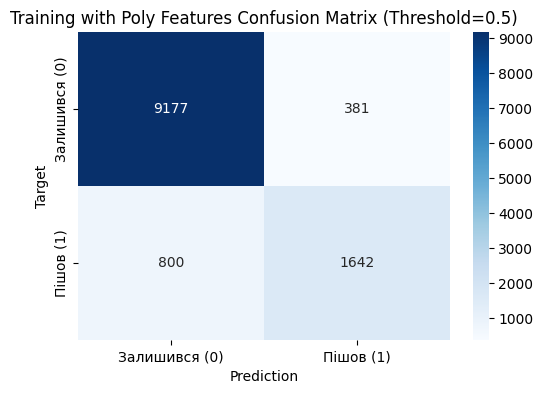


Оцінка моделі на валідаційних даних:
Area under ROC score on Validation with Poly Features dataset: 0.9275


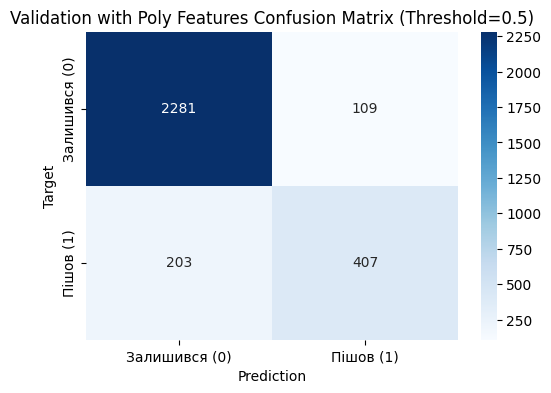

In [16]:
# Оцінюємо модель на тренувальних та валідаційних даних

print("Оцінка моделі на тренувальних даних:")
train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name='Training with Poly Features')

print("\nОцінка моделі на валідаційних даних:")
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name='Validation with Poly Features')

**Спостереження**

- Спостерігається значне покращення AUROC на тренувальних даних - з 0.8825 до 0.9303

- AUROC на валідаційних даних також значно зріс з 0.8797 до 0.9275. Це великий стрибок у розрізнювальній здатності моделі.

- Різниця між AUROC на тренувальних і валідаційних даних становить:
 - Без поліномів: 0.8825 - 0.8797 = 0.0028
 - З поліномами: 0.9303 - 0.9275 = 0.0028

Різниця між метриками на тренувальному та валідаційному наборах залишилася мінімальною. Це свідчить про те, що overfitting не спостерігається. Модель добре узагальнює нові, невидимі дані, оскільки її продуктивність на валідації майже така ж, як і на тренуванні.

- Спостерігається покращення для класу 1 (Пішов): на валідаційних даних кількість правильно передбачених клієнтів, що йдуть (TP), зросла з 346 до 407.

- Також на Confusion Matrix видно зменшення помилок: кількість клієнтів, що пішли, але яких ми пропустили (FN), значно зменшилася з 264 до 203. Це означає, що повнота для класу 1 помітно зросла.

- Кількість клієнтів, які залишились, але яких модель помилково позначила як "підуть" (FP), також зменшилася з 127 до 109. Це свідчить про покращення точності.

**Виснвовк**

Ця модель значно краща. Вона добре узагальнює дані, не перенавчається. AUROC зросла з 0.88 до 0.93, що є дуже гарним результатом. Найважливіше — вона стала значно краще виявляти клієнтів, що йдуть, при цьому зменшивши кількість хибних спрацювань. Це пряме покращення для бізнес-задачі.



**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [17]:
numeric_transformer_poly4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler())
])

In [18]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num_poly4', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [21]:
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

In [22]:
model_pipeline_poly4.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_poly4',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=4,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 LogisticRegression(max_iter=2000, random_state=42))])

Оцінка моделі на тренувальних даних:
Area under ROC score on Training with Poly Features (degree 4) dataset: 0.9393


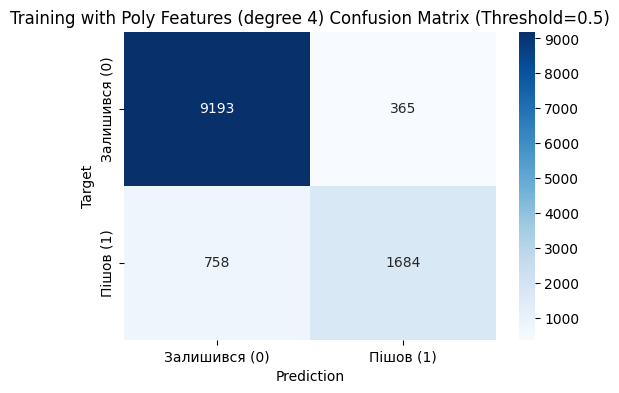


Оцінка моделі на валідаційних даних:
Area under ROC score on Validation with Poly Features (degree 4) dataset: 0.9324


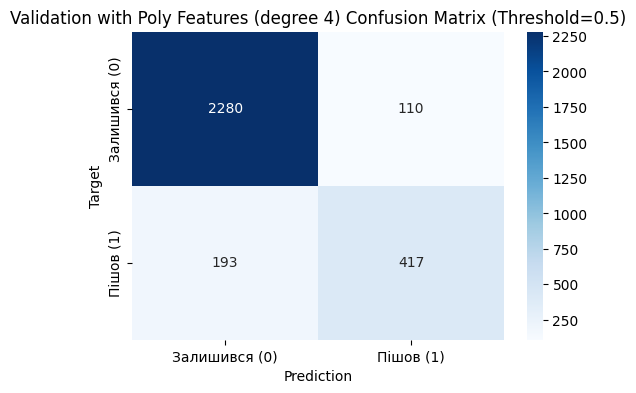

In [23]:
print("Оцінка моделі на тренувальних даних:")
train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, name='Training with Poly Features (degree 4)')

print("\nОцінка моделі на валідаційних даних:")
val_preds_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, name='Validation with Poly Features (degree 4)')

**Спостереження**

- На тренувальних даних AUROC є невиличкий зріст з 0.9303 до 0.9393. Так само спостерігається зріст AUROC на валідаційних даних. Це означає, що модель продовжує знаходити більш складні та корисні патерни у даних.

- Різниця між AUROC на тренувальному і валідаційному наборах:

 - Модель 2 (ступінь 2): 0.9303 - 0.9275 = 0.0028

 - Модель 3 (ступінь 4): 0.9393 - 0.9324 = 0.0069

Хоча розрив між тренувальною та валідаційною метриками трохи збільшився (з 0.0028 до 0.0069), він все ще дуже малий. Це не є значною ознакою перенавчання. Модель з поліномами 4-го ступеня продовжує добре узагальнювати дані.

- Аналіз Confusion Matrix:
 - Покращення для класу 1 (Пішов): Кількість TP на валідації знову зросла — з 407 до 417. Це найкращий результат з усіх трьох моделей!
 - Зменшення помилок: Кількість FN також зменшилася — з 203 до 193.
 - Незначне погіршення хибних спрацювань: Кількість FP трохи зросла з 109 до 110. Це мінімальна зміна, яка не є суттєвою.

**Висновок**

Модель з поліноміальними ознаками 4-го ступеня є найкращою з трьох. Вона демонструє найвищий показник AUROC на валідаційних даних і найкраще справляється з виявленням цільового класу.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [26]:
regression_df = pd.read_csv('drive/MyDrive/ML Course/regression_data.csv')

In [27]:
regression_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [29]:
X = regression_df.iloc[:, :-1]
y = regression_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
preprocessor_reg = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler())
])

In [33]:
model_pipeline_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])

In [35]:
model_pipeline_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('poly',
                                  PolynomialFeatures(degree=5,
                                                     include_bias=False)),
                                 ('scaler', StandardScaler())])),
                ('regressor', LinearRegression())])

In [39]:
y_train_pred = model_pipeline_reg.predict(X_train)
y_test_pred = model_pipeline_reg.predict(X_test)

In [43]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_train = np.square(mean_squared_error(y_train, y_train_pred))
rmse_test = np.square(mean_squared_error(y_test, y_test_pred))

print("Метрики якості прогностичної моделі:")
print(f"R-squared (R2) на тренувальному наборі: {r2_train:.4f}")
print(f"R-squared (R2) на тестовому наборі: {r2_test:.4f}")
print(f"RMSE на тренувальному наборі: {rmse_train:.4f}")
print(f"RMSE на тестовому наборі: {rmse_test:.4f}")

Метрики якості прогностичної моделі:
R-squared (R2) на тренувальному наборі: 1.0000
R-squared (R2) на тестовому наборі: 0.9311
RMSE на тренувальному наборі: 0.0000
RMSE на тестовому наборі: 25824.0619


**Спостереження**

- R-squared (R2) на тренувальному наборі: 1.0000. Це ідеальний результат. Модель пояснює 100% дисперсії тренувальних даних. RMSE (середньоквадратична похибка) на тренувальному наборі дорівнює 0.0000, що означає, що модель ідеально підігнана до кожного зразка в тренувальному наборі. Вона проходить через кожну точку даних.

- R-squared (R2) на тестовому наборі: 0.9311. Це все ще дуже високе значення, що свідчить про те, що модель пояснює понад 93% дисперсії в тестових даних.

- RMSE на тестовому наборі: 25824.0619.
Цей показник говорить про те, що середня похибка передбачення моделі на тестових даних становить приблизно 25 824 одиниці цільової змінної.

**Висновок**
Чи модель хороша? З точки зору R2, модель демонструє душе хорошу якість передбачень, але модель явно демонструє ознаки перенавчання: розрив мід R2 на тренувальному і тестовому наборах показує зо вона скоріш запамʼятала кожну точку в тренувальному наборі, а не навчалась. Підозрюю що на інших наборах даних ця модель може завалитися.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [44]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [46]:
preprocessor_poly20 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=20, include_bias=False)),
    ('scaler', StandardScaler())
])

In [47]:
X_train_processed_temp = preprocessor_poly20.fit_transform(X_train)

In [49]:
# Словник з моделями для зручності

models = {
    'LinearRegression': LinearRegression(),
    'Lasso (alpha=1.0)': Lasso(alpha=1.0, max_iter=5000),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, max_iter=5000),
    'ElasticNet (alpha=1.0, l1_ratio=0.5)': ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=5000)
}

In [51]:
results_df = pd.DataFrame(columns=['R2_Train', 'R2_Test', 'RMSE_Train', 'RMSE_Test'])

In [54]:
# Тренуємо та оцінюємо кожну модель

for name, model in models.items():
    print(f"Тренуємо модель: {name}...")

    # Створюємо пайплайн для поточної моделі
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_poly20),
        ('regressor', model)
    ])

    # Тренування
    full_pipeline.fit(X_train, y_train)

    # Передбачення
    y_train_pred = full_pipeline.predict(X_train)
    y_test_pred = full_pipeline.predict(X_test)

    # Обчислення метрик
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_train = np.square(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.square(mean_squared_error(y_test, y_test_pred))
    # Збереження результатів
    results_df.loc[name] = [r2_train, r2_test, rmse_train, rmse_test]
    print(f"Тренування {name} завершено.")

Тренуємо модель: LinearRegression...
Тренування LinearRegression завершено.
Тренуємо модель: Lasso (alpha=1.0)...
Тренування Lasso (alpha=1.0) завершено.
Тренуємо модель: Ridge (alpha=1.0)...
Тренування Ridge (alpha=1.0) завершено.
Тренуємо модель: ElasticNet (alpha=1.0, l1_ratio=0.5)...
Тренування ElasticNet (alpha=1.0, l1_ratio=0.5) завершено.


In [55]:
print("\n" + "="*70)
print("              РЕЗУЛЬТАТИ ПОРІВНЯННЯ МОДЕЛЕЙ")
print("="*70)
print(results_df.round(4))
print("="*70)


              РЕЗУЛЬТАТИ ПОРІВНЯННЯ МОДЕЛЕЙ
                                      R2_Train  R2_Test  RMSE_Train  \
LinearRegression                        1.0000  -0.8328      0.0000   
Lasso (alpha=1.0)                       0.9989   0.9992      4.7897   
Ridge (alpha=1.0)                       0.9994   0.6688      1.2326   
ElasticNet (alpha=1.0, l1_ratio=0.5)    0.9255   0.8177  21044.0972   

                                         RMSE_Test  
LinearRegression                      1.828424e+07  
Lasso (alpha=1.0)                     3.755900e+00  
Ridge (alpha=1.0)                     5.970758e+05  
ElasticNet (alpha=1.0, l1_ratio=0.5)  1.809222e+05  


In [57]:
print("\nАналіз кількості ненульових коефіцієнтів:")

for name, model in models.items():
    if name != 'LinearRegression':
        coefs = full_pipeline.named_steps['regressor'].coef_
        non_zero_coefs = np.sum(coefs != 0)
        print(f"Модель '{name}': {non_zero_coefs} ненульових коефіцієнтів.")


Аналіз кількості ненульових коефіцієнтів:
Модель 'Lasso (alpha=1.0)': 130 ненульових коефіцієнтів.
Модель 'Ridge (alpha=1.0)': 130 ненульових коефіцієнтів.
Модель 'ElasticNet (alpha=1.0, l1_ratio=0.5)': 130 ненульових коефіцієнтів.


**Спостереження**

1. LinearRegression

Навчання: R2 = 1.0000 і RMSE = 0.0000 на тренувальному наборі. Це означає, що модель ідеально підігналася під тренувальні дані. Вона проходить через кожну точку даних і повністю "запам'ятала" їх, включаючи шум.

Тест: R2 = -0.8328. Негативний R2 означає, що модель працює гірше, ніж просто передбачення середнього значення цільової змінної.

Ця модель демонструє сильне перенавчання.

2. Lasso (L1 регуляризація)

Навчання: R2 = 0.9989. Майже ідеальна підгонка.

Тест: R2 = 0.9992 і RMSE = 3.76. Це дуже крутий результат. Модель пояснює понад 99.9% дисперсії в тестових даних.

Аналіз коефіцієнтів: Lasso залишив лише 130 ненульових коефіцієнтів. Це означає, що він обнулив коефіцієнти для всіх ознак, які вважав надлишковими або неінформативними.

3. Ridge (L2 регуляризація)

Навчання: R2 = 0.9994. Також дуже високий, близький до LinearRegression.

Тест: R2 = 0.6688. Це значно краще, ніж у LinearRegression, але набагато гірше, ніж у Lasso.

4. ElasticNet

Навчання/Тест: Показує гірші результати, ніж Lasso та Ridge. Це може бути пов'язано з тим, що параметр l1_ratio (0.5) або alpha (1.0) не є оптимальним для цих даних. Ці параметри є гіперпараметрами, які потребують налаштування.

**Висновок**

Найкраще генералізує модель Lasso. Вона має найвищий R2 на тестовому наборі (0.9992) і найнижчий RMSE (3.76). Це прямий доказ того, що вона найкраще працює на нових, невидимих даних.
